In [1]:
import time
import torch
import sbi.utils as utils
from sbi.inference.base import infer
from sbi.analysis.plot import pairplot
import numpy as np
import pyross
from matplotlib import pyplot as plt
from memilio.epidata import getCaseData, getPopulationData
from memiliflow.data.case_data import CaseData
from datetime import date
import pandas as pd
from memiliflow.memilio.oseir import Oseir
#from memiliflow.data.case_studies import get_RKI_case_data_2020_ma7


/p/project/atmlaml/bazarova1/memiliflow/sc_venv_template/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-29 19:45:27,356	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
def simulator2(parameters):
    

    theta = [995100, 3000, 1900, 0]
    compartments = {
        Oseir.Compartment.SUSCEPTIBLE: theta[0],
        Oseir.Compartment.EXPOSED: theta[1],
        Oseir.Compartment.INFECTED: theta[2],
        Oseir.Compartment.RECOVERED: theta[3],
    }

    eps=0.0001
    minimum_contacts = 0
    damping = 0
    

    parameters=torch.squeeze(parameters)
    
    parameters_i = {
        Oseir.Parameter.TIME_EXPOSED: 1.0/0.85,
        Oseir.Parameter.TIME_INFECTED: 1.0/(parameters[0]+parameters[2]),
        Oseir.Parameter.TRANSMISSION_PROBABILITY: parameters[0],
        Oseir.Parameter.CONTACT_BASELINE: 1.0,  # np.array(theta[6]),
        Oseir.Parameter.CONTACT_MINIMUM: 0.0,  # np.array(theta[7]),
        Oseir.Parameter.CONTACT_DAMPING: 0.0,  # np.array(theta[8]),
    }

    parameters_m = {
        Oseir.Parameter.TIME_EXPOSED: 1.0/0.85,
        Oseir.Parameter.TIME_INFECTED: 1.0/(parameters[0]+parameters[2]),
        Oseir.Parameter.TRANSMISSION_PROBABILITY: parameters[0]+parameters[1],
        Oseir.Parameter.CONTACT_BASELINE: 1.0,  # np.array(theta[6]),
        Oseir.Parameter.CONTACT_MINIMUM: 0.0,  # np.array(theta[7]),
        Oseir.Parameter.CONTACT_DAMPING: 0.0,  # np.array(theta[8]),
    }
    

    Tf = 18  # reduce time span if sim is too slow
    Nf = Tf + 1

    result = Oseir.simulate_dicts(initial_condition=compartments, parameters=parameters_i,duration=Tf)

    compartments2 = {
        Oseir.Compartment.SUSCEPTIBLE: result["Susceptible"][Tf],
        Oseir.Compartment.EXPOSED: result["Exposed"][Tf],
        Oseir.Compartment.INFECTED: result["Infected"][Tf],
        Oseir.Compartment.RECOVERED: result["Recovered"][Tf],
    }

    result2 = Oseir.simulate_dicts(initial_condition=compartments2, parameters=parameters_m,duration=70-Tf)

    result2["Confirmed"]=result2["Infected"][1:] + result2["Recovered"][1:]

    result["Confirmed"] = result["Infected"] + result["Recovered"]
    result = result["Confirmed"].to_numpy().copy()
    result2=result2["Confirmed"].to_numpy().copy()

    result=np.concatenate((result,result2))
    result=result[~np.isnan(result)]


    data_array=torch.from_numpy(result)
    return data_array 

simulator without change in transmission rate

In [2]:
def simulator4(parameters):
    
    
    total_population=83e6
    mean_gamma_I = 1 / 14

    parameters=torch.squeeze(parameters)
    theta = [parameters[0], parameters[1], 0,parameters[2],mean_gamma_I,parameters[3]]

    #print("here 1!!!!!!!!!!!!")
    #print(1.0/parameters[2],"parameters time exposed!!!!!!!!!!!!!!!!")
    
        
    compartments = {
        Oseir.Compartment.SUSCEPTIBLE: total_population-theta[0]-theta[1]-theta[2],
        Oseir.Compartment.EXPOSED: theta[0],
        Oseir.Compartment.INFECTED: theta[1],
        Oseir.Compartment.RECOVERED: theta[2],
    }

    #print("here 2!!!!!!!!!!!!")

    eps=0.0001
    minimum_contacts = 0
    damping = 0
    

    
    parameters_i = {
        Oseir.Parameter.TIME_EXPOSED: 1.0/theta[3],
        Oseir.Parameter.TIME_INFECTED: 1.0/theta[4],
        Oseir.Parameter.TRANSMISSION_PROBABILITY: 1.0,
        Oseir.Parameter.CONTACT_BASELINE:  theta[5],
        Oseir.Parameter.CONTACT_MINIMUM: 0.0,  # np.array(theta[7]),
        Oseir.Parameter.CONTACT_DAMPING: 0.0,  # np.array(theta[8]),
    }

    #print("here 3!!!!!!!!!!!!")

    #print(parameters_i, " parameters!!!!!!!!!!!!!!")

    Tf = 14  # reduce time span if sim is too slow
    Nf = Tf + 1

    #print("here 4!!!!!!!!!!!!")

    result = Oseir.simulate_dicts(initial_condition=compartments, parameters=parameters_i,duration=Tf)

    #print("here 5!!!!!!!!!!!!")
    #print(result["Infected"][:10])
    result["Confirmed"] = result["Infected"] + result["Recovered"]
    result["Daily_new_cases"]=result["Confirmed"].diff()
    result=result[result["Daily_new_cases"].notna()]
    #result=np.asarray(result)
    #print(result)
    result=result["Daily_new_cases"].to_numpy().copy()
    #print(result)
    #result = result["Confirmed"].to_numpy().copy()

    data_array=torch.from_numpy(result)
    return data_array 

In [3]:
data={"Date":"2020-03-01","Confirmed":1902.4285714286,"Deaths":43.0,"Recovered":1859.4285714286},{"Date":"2020-03-02","Confirmed":2206.5714285714,"Deaths":50.1428571429,"Recovered":2156.4285714286},{"Date":"2020-03-03","Confirmed":2575.8571428571,"Deaths":59.4285714286,"Recovered":2516.4285714286},{"Date":"2020-03-04","Confirmed":3034.7142857143,"Deaths":71.5714285714,"Recovered":2963.1428571429},{"Date":"2020-03-05","Confirmed":3619.0,"Deaths":86.2857142857,"Recovered":3532.7142857143},{"Date":"2020-03-06","Confirmed":4415.0,"Deaths":103.2857142857,"Recovered":4311.7142857143},{"Date":"2020-03-07","Confirmed":5491.0,"Deaths":123.7142857143,"Recovered":5367.2857142857},{"Date":"2020-03-08","Confirmed":6912.8571428571,"Deaths":149.5714285714,"Recovered":6763.2857142857},{"Date":"2020-03-09","Confirmed":8721.5714285714,"Deaths":182.7142857143,"Recovered":8538.8571428571},{"Date":"2020-03-10","Confirmed":10993.8571428571,"Deaths":224.4285714286,"Recovered":10769.4285714286},{"Date":"2020-03-11","Confirmed":13707.5714285714,"Deaths":271.7142857143,"Recovered":13435.8571428571},{"Date":"2020-03-12","Confirmed":16841.2857142857,"Deaths":329.7142857143,"Recovered":16511.5714285714},{"Date":"2020-03-13","Confirmed":20505.1428571429,"Deaths":403.5714285714,"Recovered":20101.5714285714},{"Date":"2020-03-14","Confirmed":24549.1428571429,"Deaths":490.7142857143,"Recovered":24058.4285714286},{"Date":"2020-03-15","Confirmed":28924.0,"Deaths":591.7142857143,"Recovered":28332.2857142857},{"Date":"2020-03-16","Confirmed":33503.2857142857,"Deaths":702.4285714286,"Recovered":32800.8571428571},{"Date":"2020-03-17","Confirmed":38265.8571428571,"Deaths":830.0,"Recovered":37435.8571428571},{"Date":"2020-03-18","Confirmed":43075.4285714286,"Deaths":969.4285714286,"Recovered":42106.0},{"Date":"2020-03-19","Confirmed":47794.4285714286,"Deaths":1113.4285714286,"Recovered":46681.0},{"Date":"2020-03-20","Confirmed":52439.8571428571,"Deaths":1274.5714285714,"Recovered":51165.2857142857},{"Date":"2020-03-21","Confirmed":56958.7142857143,"Deaths":1447.8571428571,"Recovered":55510.8571428571},{"Date":"2020-03-22","Confirmed":61394.1428571429,"Deaths":1637.2857142857,"Recovered":59756.8571428571},{"Date":"2020-03-23","Confirmed":65782.7142857143,"Deaths":1841.1428571429,"Recovered":63941.5714285714},{"Date":"2020-03-24","Confirmed":70062.2857142857,"Deaths":2053.7142857143,"Recovered":68008.5714285714},{"Date":"2020-03-25","Confirmed":74301.5714285714,"Deaths":2283.5714285714,"Recovered":72018.0},{"Date":"2020-03-26","Confirmed":78484.7142857143,"Deaths":2520.2857142857,"Recovered":75964.4285714286},{"Date":"2020-03-27","Confirmed":82580.5714285714,"Deaths":2765.2857142857,"Recovered":79815.2857142857},{"Date":"2020-03-28","Confirmed":86664.7142857143,"Deaths":3018.1428571429,"Recovered":83646.5714285714},{"Date":"2020-03-29","Confirmed":90732.2857142857,"Deaths":3278.5714285714,"Recovered":87453.7142857143},{"Date":"2020-03-30","Confirmed":94794.8571428571,"Deaths":3553.1428571429,"Recovered":91241.7142857143},{"Date":"2020-03-31","Confirmed":98846.7142857143,"Deaths":3839.8571428571,"Recovered":95006.8571428571},{"Date":"2020-04-01","Confirmed":102799.7142857143,"Deaths":4122.1428571429,"Recovered":98677.5714285714},{"Date":"2020-04-02","Confirmed":106698.2857142857,"Deaths":4408.0,"Recovered":102290.2857142857},{"Date":"2020-04-03","Confirmed":110474.4285714286,"Deaths":4691.4285714286,"Recovered":105783.0},{"Date":"2020-04-04","Confirmed":114176.8571428571,"Deaths":4974.0,"Recovered":109202.8571428571},{"Date":"2020-04-05","Confirmed":117736.4285714286,"Deaths":5251.4285714286,"Recovered":112485.0},{"Date":"2020-04-06","Confirmed":121161.0,"Deaths":5518.1428571429,"Recovered":115642.8571428571},{"Date":"2020-04-07","Confirmed":124328.4285714286,"Deaths":5764.4285714286,"Recovered":118564.0},{"Date":"2020-04-08","Confirmed":127361.8571428571,"Deaths":6001.2857142857,"Recovered":121360.5714285714},{"Date":"2020-04-09","Confirmed":130289.5714285714,"Deaths":6231.5714285714,"Recovered":124058.0},{"Date":"2020-04-10","Confirmed":132971.4285714286,"Deaths":6437.5714285714,"Recovered":126533.8571428571},{"Date":"2020-04-11","Confirmed":135455.4285714286,"Deaths":6628.2857142857,"Recovered":128827.1428571429},{"Date":"2020-04-12","Confirmed":137765.8571428571,"Deaths":6803.0,"Recovered":130962.8571428571},{"Date":"2020-04-13","Confirmed":139913.7142857143,"Deaths":6960.0,"Recovered":132953.7142857143},{"Date":"2020-04-14","Confirmed":142007.2857142857,"Deaths":7106.8571428571,"Recovered":134900.4285714286},{"Date":"2020-04-15","Confirmed":144005.5714285714,"Deaths":7244.0,"Recovered":136761.5714285714},{"Date":"2020-04-16","Confirmed":145917.4285714286,"Deaths":7373.4285714286,"Recovered":138544.0},{"Date":"2020-04-17","Confirmed":147805.8571428571,"Deaths":7502.1428571429,"Recovered":140303.7142857143},{"Date":"2020-04-18","Confirmed":149615.8571428571,"Deaths":7623.1428571429,"Recovered":141992.7142857143},{"Date":"2020-04-19","Confirmed":151349.8571428571,"Deaths":7734.2857142857,"Recovered":143615.5714285714},{"Date":"2020-04-20","Confirmed":153001.4285714286,"Deaths":7841.2857142857,"Recovered":145160.1428571429},{"Date":"2020-04-21","Confirmed":154548.2857142857,"Deaths":7939.5714285714,"Recovered":146608.7142857143},{"Date":"2020-04-22","Confirmed":156019.4285714286,"Deaths":8032.2857142857,"Recovered":147987.1428571429},{"Date":"2020-04-23","Confirmed":157418.1428571429,"Deaths":8115.5714285714,"Recovered":149302.5714285714},{"Date":"2020-04-24","Confirmed":158752.5714285714,"Deaths":8190.7142857143,"Recovered":150561.8571428571},{"Date":"2020-04-25","Confirmed":160025.1428571429,"Deaths":8260.7142857143,"Recovered":151764.4285714286},{"Date":"2020-04-26","Confirmed":161209.7142857143,"Deaths":8326.0,"Recovered":152883.7142857143},{"Date":"2020-04-27","Confirmed":162332.1428571429,"Deaths":8385.4285714286,"Recovered":153946.7142857143},{"Date":"2020-04-28","Confirmed":163370.7142857143,"Deaths":8440.4285714286,"Recovered":154930.2857142857},{"Date":"2020-04-29","Confirmed":164347.0,"Deaths":8490.1428571429,"Recovered":155856.8571428571},{"Date":"2020-04-30","Confirmed":165294.5714285714,"Deaths":8538.1428571429,"Recovered":156756.4285714286},{"Date":"2020-05-01","Confirmed":166193.4285714286,"Deaths":8582.8571428571,"Recovered":157610.5714285714},{"Date":"2020-05-02","Confirmed":167065.8571428571,"Deaths":8623.7142857143,"Recovered":158442.1428571429},{"Date":"2020-05-03","Confirmed":167913.1428571429,"Deaths":8659.5714285714,"Recovered":159253.5714285714},{"Date":"2020-05-04","Confirmed":168719.1428571429,"Deaths":8692.1428571429,"Recovered":160027.0},{"Date":"2020-05-05","Confirmed":169516.0,"Deaths":8724.2857142857,"Recovered":160791.7142857143},{"Date":"2020-05-06","Confirmed":170300.7142857143,"Deaths":8754.0,"Recovered":161546.7142857143},{"Date":"2020-05-07","Confirmed":171064.4285714286,"Deaths":8783.8571428571,"Recovered":162280.5714285714},{"Date":"2020-05-08","Confirmed":171806.7142857143,"Deaths":8810.7142857143,"Recovered":162996.0},{"Date":"2020-05-09","Confirmed":172512.5714285714,"Deaths":8834.5714285714,"Recovered":163678.0},{"Date":"2020-05-10","Confirmed":173188.8571428571,"Deaths":8858.4285714286,"Recovered":164330.4285714286},{"Date":"2020-05-11","Confirmed":173833.8571428571,"Deaths":8879.4285714286,"Recovered":164954.4285714286},{"Date":"2020-05-12","Confirmed":174469.2857142857,"Deaths":8899.8571428571,"Recovered":165569.4285714286},{"Date":"2020-05-13","Confirmed":175090.7142857143,"Deaths":8922.5714285714,"Recovered":166168.1428571429},{"Date":"2020-05-14","Confirmed":175704.7142857143,"Deaths":8943.5714285714,"Recovered":166761.1428571429},{"Date":"2020-05-15","Confirmed":176310.5714285714,"Deaths":8963.1428571429,"Recovered":167347.4285714286},{"Date":"2020-05-16","Confirmed":176900.8571428571,"Deaths":8982.0,"Recovered":167918.8571428571},{"Date":"2020-05-17","Confirmed":177491.0,"Deaths":9001.4285714286,"Recovered":168489.5714285714},{"Date":"2020-05-18","Confirmed":178049.5714285714,"Deaths":9019.4285714286,"Recovered":169030.1428571429},{"Date":"2020-05-19","Confirmed":178565.1428571429,"Deaths":9034.8571428571,"Recovered":169530.2857142857},{"Date":"2020-05-20","Confirmed":179058.5714285714,"Deaths":9048.4285714286,"Recovered":170010.1428571429},{"Date":"2020-05-21","Confirmed":179537.5714285714,"Deaths":9061.0,"Recovered":170476.5714285714},{"Date":"2020-05-22","Confirmed":179992.2857142857,"Deaths":9073.1428571429,"Recovered":170919.1428571429},{"Date":"2020-05-23","Confirmed":180451.4285714286,"Deaths":9085.5714285714,"Recovered":171365.8571428571},{"Date":"2020-05-24","Confirmed":180885.4285714286,"Deaths":9095.5714285714,"Recovered":171789.8571428571},{"Date":"2020-05-25","Confirmed":181323.5714285714,"Deaths":9106.0,"Recovered":172217.5714285714},{"Date":"2020-05-26","Confirmed":181753.8571428571,"Deaths":9115.2857142857,"Recovered":172638.5714285714},{"Date":"2020-05-27","Confirmed":182183.4285714286,"Deaths":9123.7142857143,"Recovered":173059.7142857143},{"Date":"2020-05-28","Confirmed":182602.0,"Deaths":9132.2857142857,"Recovered":173469.7142857143},{"Date":"2020-05-29","Confirmed":182989.7142857143,"Deaths":9140.4285714286,"Recovered":173849.2857142857},{"Date":"2020-05-30","Confirmed":183346.1428571429,"Deaths":9147.4285714286,"Recovered":174198.7142857143},{"Date":"2020-05-31","Confirmed":183693.1428571429,"Deaths":9153.2857142857,"Recovered":174539.8571428571}
# data={"Date":"2020-03-01","Confirmed":1902.4285714286,"Deaths":43.0,"Recovered":1859.4285714286},{"Date":"2020-03-02","Confirmed":2206.5714285714,"Deaths":50.1428571429,"Recovered":2156.4285714286},{"Date":"2020-03-03","Confirmed":2575.8571428571,"Deaths":59.4285714286,"Recovered":2516.4285714286},{"Date":"2020-03-04","Confirmed":3034.7142857143,"Deaths":71.5714285714,"Recovered":2963.1428571429},{"Date":"2020-03-05","Confirmed":3619.0,"Deaths":86.2857142857,"Recovered":3532.7142857143},{"Date":"2020-03-06","Confirmed":4415.0,"Deaths":103.2857142857,"Recovered":4311.7142857143},{"Date":"2020-03-07","Confirmed":5491.0,"Deaths":123.7142857143,"Recovered":5367.2857142857},{"Date":"2020-03-08","Confirmed":6912.8571428571,"Deaths":149.5714285714,"Recovered":6763.2857142857},{"Date":"2020-03-09","Confirmed":8721.5714285714,"Deaths":182.7142857143,"Recovered":8538.8571428571},{"Date":"2020-03-10","Confirmed":10993.8571428571,"Deaths":224.4285714286,"Recovered":10769.4285714286},{"Date":"2020-03-11","Confirmed":13707.5714285714,"Deaths":271.7142857143,"Recovered":13435.8571428571},{"Date":"2020-03-12","Confirmed":16841.2857142857,"Deaths":329.7142857143,"Recovered":16511.5714285714},{"Date":"2020-03-13","Confirmed":20505.1428571429,"Deaths":403.5714285714,"Recovered":20101.5714285714},{"Date":"2020-03-14","Confirmed":24549.1428571429,"Deaths":490.7142857143,"Recovered":24058.4285714286},{"Date":"2020-03-15","Confirmed":28924.0,"Deaths":591.7142857143,"Recovered":28332.2857142857},{"Date":"2020-03-16","Confirmed":33503.2857142857,"Deaths":702.4285714286,"Recovered":32800.8571428571},{"Date":"2020-03-17","Confirmed":38265.8571428571,"Deaths":830.0,"Recovered":37435.8571428571},{"Date":"2020-03-18","Confirmed":43075.4285714286,"Deaths":969.4285714286,"Recovered":42106.0},{"Date":"2020-03-19","Confirmed":47794.4285714286,"Deaths":1113.4285714286,"Recovered":46681.0},{"Date":"2020-03-20","Confirmed":52439.8571428571,"Deaths":1274.5714285714,"Recovered":51165.2857142857},{"Date":"2020-03-21","Confirmed":56958.7142857143,"Deaths":1447.8571428571,"Recovered":55510.8571428571},{"Date":"2020-03-22","Confirmed":61394.1428571429,"Deaths":1637.2857142857,"Recovered":59756.8571428571},{"Date":"2020-03-23","Confirmed":65782.7142857143,"Deaths":1841.1428571429,"Recovered":63941.5714285714},{"Date":"2020-03-24","Confirmed":70062.2857142857,"Deaths":2053.7142857143,"Recovered":68008.5714285714},{"Date":"2020-03-25","Confirmed":74301.5714285714,"Deaths":2283.5714285714,"Recovered":72018.0},{"Date":"2020-03-26","Confirmed":78484.7142857143,"Deaths":2520.2857142857,"Recovered":75964.4285714286},{"Date":"2020-03-27","Confirmed":82580.5714285714,"Deaths":2765.2857142857,"Recovered":79815.2857142857},{"Date":"2020-03-28","Confirmed":86664.7142857143,"Deaths":3018.1428571429,"Recovered":83646.5714285714},{"Date":"2020-03-29","Confirmed":90732.2857142857,"Deaths":3278.5714285714,"Recovered":87453.7142857143},{"Date":"2020-03-30","Confirmed":94794.8571428571,"Deaths":3553.1428571429,"Recovered":91241.7142857143},{"Date":"2020-03-31","Confirmed":98846.7142857143,"Deaths":3839.8571428571,"Recovered":95006.8571428571}
pd.DataFrame.from_dict(data)
casedata=CaseData({"cases_all_germany_ma7": pd.DataFrame.from_dict(data=data)})
casedata.data["cases_all_germany_ma7"].iloc[:30]

Date     Confirmed       Deaths     Recovered
0   2020-03-01   1902.428571    43.000000   1859.428571
1   2020-03-02   2206.571429    50.142857   2156.428571
2   2020-03-03   2575.857143    59.428571   2516.428571
3   2020-03-04   3034.714286    71.571429   2963.142857
4   2020-03-05   3619.000000    86.285714   3532.714286
5   2020-03-06   4415.000000   103.285714   4311.714286
6   2020-03-07   5491.000000   123.714286   5367.285714
7   2020-03-08   6912.857143   149.571429   6763.285714
8   2020-03-09   8721.571429   182.714286   8538.857143
9   2020-03-10  10993.857143   224.428571  10769.428571
10  2020-03-11  13707.571429   271.714286  13435.857143
11  2020-03-12  16841.285714   329.714286  16511.571429
12  2020-03-13  20505.142857   403.571429  20101.571429
13  2020-03-14  24549.142857   490.714286  24058.428571
14  2020-03-15  28924.000000   591.714286  28332.285714
15  2020-03-16  33503.285714   702.428571  32800.857143
16  2020-03-17  38265.857143   830.000000  37435.857143
17  2020-03-18  43075.428571   969.428571  42106.000000
18  2020-03-19  47794.428571  1113.428571  46681.000000
19  2020-03-20  52439.857143  1274.571429  51165.285714
20  2020-03-21  56958.714286  1447.857143  55510.857143
21  2020-03-22  61394.142857  1637.285714  59756.857143
22  2020-03-23  65782.714286  1841.142857  63941.571429
23  2020-03-24  70062.285714  2053.714286  68008.571429
24  2020-03-25  74301.571429  2283.571429  72018.000000
25  2020-03-26  78484.714286  2520.285714  75964.428571
26  2020-03-27  82580.571429  2765.285714  79815.285714
27  2020-03-28  86664.714286  3018.142857  83646.571429
28  2020-03-29  90732.285714  3278.571429  87453.714286
29  2020-03-30  94794.857143  3553.142857  91241.714286

In [4]:
from sbi.utils import MultipleIndependent


# prior = utils.BoxUniform(
#     low=torch.tensor([3, 3,0.01,0.01]),
#     high=torch.tensor([21,14,1,5])
# )


#prior for the simulator2 with change and simulator3 with pyross 

# prior = utils.BoxUniform(
#     low=torch.tensor([0.8,-0.3,-0.3]),
#     high=torch.tensor([1.5,0.1,0.1])
# )

mean_gamma_E =0.25


prior=MultipleIndependent(
    [
        torch.distributions.HalfCauchy(torch.tensor([100.0])),
        torch.distributions.HalfCauchy(torch.tensor([100.0])),
        torch.distributions.LogNormal(torch.log(torch.tensor(mean_gamma_E)), torch.tensor([0.1])),
        torch.distributions.LogNormal(torch.log(torch.tensor([0.5])),torch.tensor([1]))
    ],
    validate_args=False,
)



tensor([-1.3863]) tensor([-0.6931])  dists!!!!!!!!!!!!!
[HalfCauchy(), HalfCauchy(), LogNormal(), LogNormal()]  dists!!!!!!!!!!!!!


tensor(0.0004) tensor(322487.7188) tensor(67.5349) 0.25


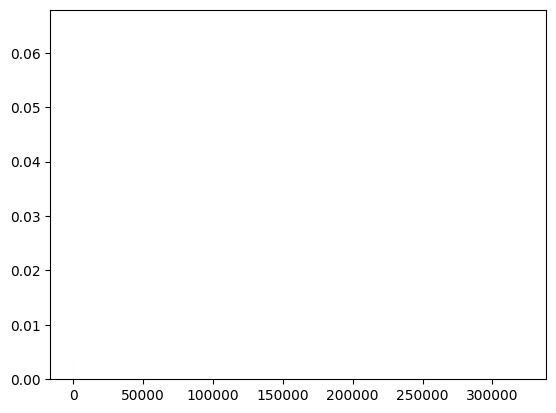

tensor(99389)

In [78]:
mean_gamma_E=0.25
#a=torch.distributions.LogNormal(loc=np.log(0.5),scale= 1.0)
a=torch.distributions.HalfCauchy(10)
b=a.sample(sample_shape=torch.Size([100000]))
%matplotlib inline
#plt.plot(a.sample(sample_shape=torch.Size([1000000])))

print(torch.min(b),torch.max(b),torch.mean(b),mean_gamma_E)
fig, ax = plt.subplots(1, 1)
ax.hist(b, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
#ax.set_xlim([x[0], x[-1]])
#ax.legend(loc='best', frameon=False)
#plt.xlim((0,5))
plt.show()
c=1/b
torch.sum(torch.abs(c)>0.001)
#print(a.loc, np.log(mean_gamma_E))


In [7]:
num_sim = 1000
method = 'SNPE' #SNPE or SNLE or SNRE
posterior = infer(
    simulator4,
    prior,
    # See glossary for explanation of methods.
    #    SNRE newer than SNLE newer than SNPE.
    method=method,
    num_workers=-1,
    num_simulations=num_sim)

method!!!!!!!!!!!!!!!
[HalfCauchy(), HalfCauchy(), LogNormal(), LogNormal()]  distributions!!!!!!


RuntimeError: zero-dimensional tensor (at position 0) cannot be concatenated

checking how close the simulations are to the actual data 

tensor([ 4.7144,  4.7893, -1.3815, -0.7658])
tensor(5.1404)tensor(4.3503)tensor(3.9634)tensor(4.1236)tensor(4.1419)tensor(3.7452)  tensor(4.3304)tensor(3.9604)   tensor(3.6659) parameters time exposed!!!!!!!!!!!!!!!!parameters time exposed!!!!!!!!!!!!!!!! parameters time exposed!!!!!!!!!!!!!!!!parameters time exposed!!!!!!!!!!!!!!!! parameters time exposed!!!!!!!!!!!!!!!!
parameters time exposed!!!!!!!!!!!!!!!!tensor(3.7098)
 parameters time exposed!!!!!!!!!!!!!!!!
parameters time exposed!!!!!!!!!!!!!!!!


tensor(3.8544)tensor(4.0686) parameters time exposed!!!!!!!!!!!!!!!!
tensor(4.2790)
 tensor(3.9188) 
 parameters time exposed!!!!!!!!!!!!!!!!parameters time exposed!!!!!!!!!!!!!!!! tensor(3.7466)parameters time exposed!!!!!!!!!!!!!!!!parameters time exposed!!!!!!!!!!!!!!!!

tensor(3.4192)parameters time exposed!!!!!!!!!!!!!!!! tensor(3.8605)

tensor(3.8492) 
parameters time exposed!!!!!!!!!!!!!!!!  parameters time exposed!!!!!!!!!!!!!!!!tensor(4.0214)
parameters time exposed!!!!!!!!!

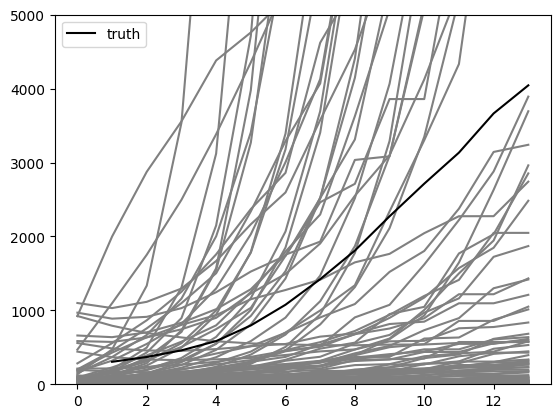

In [14]:
import multiprocessing
%matplotlib inline
y_truth=np.asarray(casedata.data['cases_all_germany_ma7'].Confirmed.diff())[:14]


plt.plot(y_truth, "k", zorder=1, label="truth")
n_samples = 100
params = prior.sample((n_samples,))
print(torch.mean(torch.log(params),axis=0))
#params=np.asarray(params)
#type(params)

with multiprocessing.Pool() as pool:
     y_=[result for result in pool.map(simulator4, params)]

y_=torch.stack(y_)
y_=np.asarray(y_)
#print.shape

plt.plot(y_.T, "grey", zorder=0)
plt.ylim(0, 5000)
#plt.plot(x.T, "grey", zorder=0)
plt.legend()
plt.show()

Flexible inference using MSE with the true trajectory

In [5]:
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi,SNRE, SNLE

theta,x=simulate_for_sbi(simulator4,prior,10000,num_workers=-1,simulation_batch_size=1)


Running 10000 simulations in 10000 batches.:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 10000 simulations in 10000 batches.: 100%|██████████| 10000/10000 [01:42<00:00, 97.36it/s]


summary statistic

In [6]:
y_truth=np.asarray(casedata.data['cases_all_germany_ma7'].Confirmed.diff())[1:15]


def get_MSE_sim(x,y_t):
    x=np.asarray(x)
    x=x.reshape((int(x.shape[0]/y_t.shape[0]),y_t.shape[0]))
    y_t=y_t.reshape((1,y_t.shape[0]))
    return np.mean(np.square(x[:,7:] - y_t[:,7:]),axis=1,keepdims=True)

x=get_MSE_sim(x,y_truth)

In [9]:
x=x.reshape((10000,int(x.shape[0]/10000)))

In [7]:
x=np.float32(x)
x=torch.from_numpy(x)

inference=SNPE(prior)

_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()


/p/project/atmlaml/bazarova1/memiliflow/sc_venv_template/venv/lib/python3.10/site-packages/sbi/utils/sbiutils.py:43: UserWarning: Z-scoring these simulation outputs resulted in {num_unique_z} unique
            datapoints. Before z-scoring, it had been {num_unique}. This can occur due
            to numerical inaccuracies when the data covers a large range of values.
            Consider either setting `z_score_x=False` (but beware that this can be
            problematic for training the NN) or exclude outliers from your dataset.
            Note: if you have already set `z_score_x=False`, this warning will still be
            displayed, but you can ignore it.
  warnings.warn(


torch.float32 torch.float32  data types!!!!!!!!!!!
 Neural network successfully converged after 165 epochs.yes transform!!!!!!!!!!!!!!!!!!!!!!
tensor([[3.4531e+02, 2.3806e+03, 2.3326e-01, 4.4370e-01],
        [2.5537e+02, 9.3404e+00, 2.3977e-01, 8.2340e-01]])  theta!!!!!!!!!!!!!!!!!!!!!!!!!
tensor([[ 5.8444,  7.7751, -1.4556, -0.8126],
        [ 5.5427,  2.2343, -1.4281, -0.1943]])  theta unconstrained!!!!!!!!!!!!!!!!
yes transform!!!!!!!!!!!!!!!!!!!!!!
tensor([[1.4475e+02, 1.0449e+02, 2.3838e-01, 7.3224e-01],
        [2.7416e+01, 3.7558e+02, 2.2123e-01, 3.9434e-01]])  theta!!!!!!!!!!!!!!!!!!!!!!!!!
tensor([[ 4.9750,  4.6491, -1.4339, -0.3117],
        [ 3.3111,  5.9285, -1.5085, -0.9305]])  theta unconstrained!!!!!!!!!!!!!!!!


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples: 10656it [00:00, 42129.25it/s]                          


torch.Size([10000, 4])


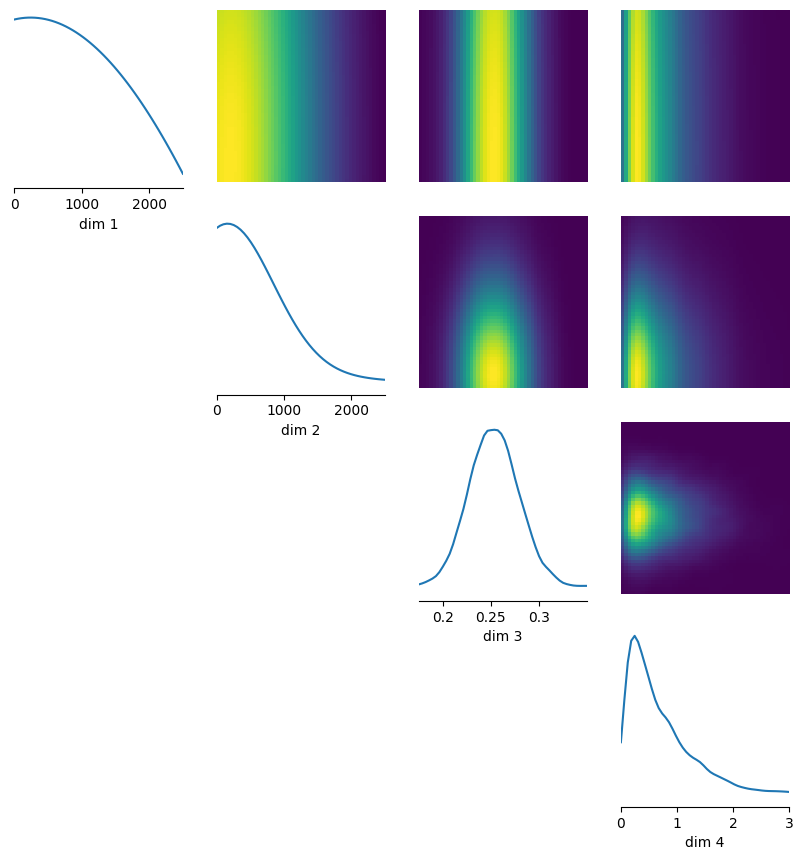

In [8]:
%matplotlib inline

y_truth= torch.as_tensor(
    [
        [
            0.0,
        ]
        
    ]
)

y_o=np.asarray(casedata.data['cases_all_germany_ma7'].Confirmed.diff())[1:15]



theta_p = posterior.sample((10000,), x=y_truth)
print(theta_p.shape)


fig, out = pairplot(theta_p, limits=[[0.,2500],[0,2500],[0.175,0.35],[0.0,3.0]], fig_size=(4,4), upper='kde', diag='kde')

In [12]:
%matplotlib inline
#observation=simulator4(torch.unsqueeze(torch.median(theta_p,axis=0),0))
observation=simulator4(torch.median(theta_p,axis=0))
#print(torch.mean(theta_p,axis=0))
#observation=simulator4(torch.unsqueeze(torch.cat((torch.tensor([1220]),torch.tensor([420]),torch.tensor([0.25]),torch.tensor([0.6]))),0))
print(torch.unsqueeze(torch.mean(theta_p,axis=0),0))
#observation=simulator4(torch.tensor([30.9090, 14.9323, 0.3716, 1.3491]))
#observation1=simulator2(np.array([1.5,0.75]))
#print(len(np.asarray(casedata.data['cases_all_germany_ma7'].Confirmed)[13:90]))
#print(observation.shape)
#observation1=data_pyross[10:87].flatten()
#print(observation1.shape)
#plt.plot(observation[0::4])

#plt.plot(observation1[0::4])
fig,ax=plt.subplots()


line1,=ax.plot(observation,label="simulated data")
line2,=ax.plot(np.asarray(casedata.data['cases_all_germany_ma7'].Confirmed.diff()[1:15]),label="RKI data")
first_legend = ax.legend(handles=[line1,line2], loc='lower right')
#ax.legend(handles=[line2], loc='upper right')
ax.add_artist(first_legend)
plt.show()

TypeError: squeeze(): argument 'input' (position 1) must be Tensor, not torch.return_types.median

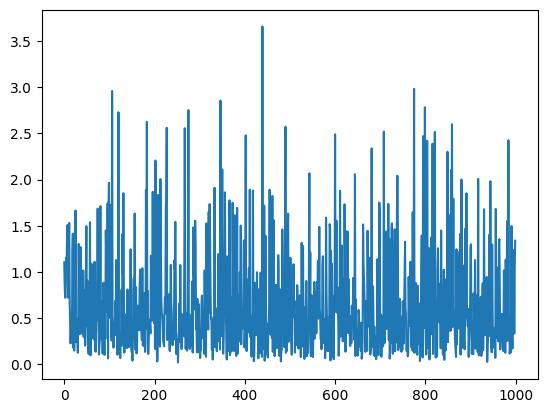

In [18]:
fig,ax=plt.subplots()
line1,=ax.plot(theta_p[:,3],label="initial_I")

oThe stuff below is for danity check with pyross

In [11]:
def simulator3(parameters):
    M = 1  # the population has one age groups
    N = 1e6  # and this is the total population
    Ni = N * np.ones(M)
    parameters=parameters.reshape((parameters.shape[0]*parameters.shape[1],))
    # parameters for generating synthetic trajectory
    #print(parameters.shape," parameters")

    beta1 = np.array(parameters[0::3]) #0.95  # infection rate
    #beta=beta1
    #print(beta1.shape," beta1 shape")
    #print(np.array(parameters[1::3]).shape," beta2 shape")

    eps=0.0001
    beta2 = np.max((beta1+np.array(parameters[1::3]),np.repeat(eps,beta1.shape[0])),axis=0)
    #beta=beta2
    #print(beta," beta!!!!!!!!!!!!!!")
    gE = 0.85#np.array(parameters[3])#0.85 #np.array(parameters[0]) #1.0 / 5.2  # recovery rate of asymptomatic infectives
    gI = np.max((beta1+np.array(parameters[2::3]),np.repeat(eps,beta1.shape[0])),axis=0)#np.max((beta1+np.array(parameters[1]),0.0001)) #1.0 / 6  # recovery rate of symptomatic infectives
    #print(beta," beta")

    # set up initial condition
    E0 = 3000 #parameters[2]
    I0 = 1900
    R0 = 0
    # E0=1496    
    # I0=844
    # R0=33993

    S0 = N - (E0 + I0 + R0)
    x0 = {"S": [S0], "E": [E0], "I": [I0], "R": [R0]}

    Tf = 70  # reduce time span if sim is too slow
    Nf = Tf + 1

    # set the contact structure
    #C = np.array([[1.0]])
    C=np.eye(M)

    # [[18., 9.],
    #           [3., 12.]])
    # C_ij = number of people group from group i that an individual from group j meets per day
    def contactMatrix(t):
        return C

    parameters = {"beta1": beta1,"beta2":beta2, "gE": gE, "gI": gI}
    true_parameters = {"beta1": beta1,"beta2":beta2, "gE": gE, "gI": gI}


    # parameters = {"beta":beta, "gE": gE, "gI": gI}
    # true_parameters = {"beta":beta, "gE": gE, "gI": gI}

    
    ### Stochastic SEIR model ###

    model_spec = {
        "classes": ["S", "E", "I", "R"],
        "S": {
            "infection": [["I", "S", "-beta"]],
        },
        "E": {"linear": [["E", "-gE"]], "infection": [["I", "S", "beta"]]},
        "I": {
            "linear": [
                ["E", "gE"],
                ["I", "-gI"],
            ],
        },
        "R": {
            "linear": [["I", "gI"]],
        },
    }

    def parameter_mapping(input_parameters, t):
        output_parameters = {
            'gE' : input_parameters['gE'] ,
            'gI' : input_parameters['gI'] 
        }
        if t<18:
            output_parameters['beta'] = input_parameters['beta1']
        else:
            output_parameters['beta'] = input_parameters['beta2']
        return output_parameters


    # use pyross stochastic to generate traj and save

    sto_model = pyross.stochastic.Model(model_spec, true_parameters, M, Ni,time_dep_param_mapping=parameter_mapping)

    #sto_model = pyross.stochastic.Model(model_spec, true_parameters, M, Ni)

    data = sto_model.simulate(x0, contactMatrix, Tf, Nf, method="tau-leaping")
    
    data_array = data["X"]


    #print(data_array[17,:]," initial_cond 2")
    
    data_array=data_array[:,2]+data_array[:,3]
    

    data_array=torch.from_numpy(data_array)
    return data_array






In [12]:
params = prior.sample((1,))
params

tensor([[ 0.8896, -0.0121, -0.2948]])

In [13]:
a1=simulator2(params)
a2=simulator3(params)

[827400.74842415  21855.72254405  27351.63828031 123391.8907515 ] initial cond


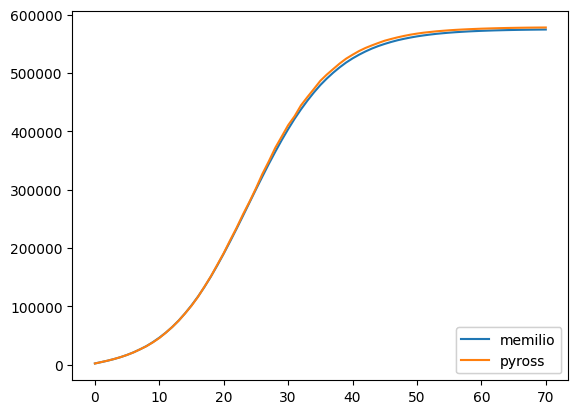

In [22]:
%matplotlib inline
a1=simulator2(params)
a2=simulator3(params)
fig,ax=plt.subplots()

line1,=ax.plot(a1,label="memilio")
line2,=ax.plot(a2,label="pyross")
first_legend = ax.legend(handles=[line1,line2], loc='lower right')
#ax.legend(handles=[line2], loc='upper right')
ax.add_artist(first_legend)
plt.show()